# Classification de séries temporelles à partir d'un réseau de neurones de convolution

### 1. Importation des bibliothèques nécessaires

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Flatten, Dense
from keras.utils import to_categorical
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder

### 2. Chargement du dataset et preprocessing

In [3]:
df = pd.read_csv('../data_index.csv', usecols=[0,1,3,4,5,6,7,8,9,10,11,12,13,14,19,20,21], parse_dates=['Date & Time'], index_col=1)
data = df.resample('15Min').mean()  # Resample par 15 minutes
data = data.dropna()
data.head()

,rowId,Generation [kW],CT15_Amperage [A],CT13_Amperage [A],CT12_Amperage [A],CT11_Amperage [A],CT10_Amperage [A],CT9_Amperage [A],CT8_Amperage [A],CT7_Amperage [A],CT6_Amperage [A],CT3_Amperage [A],CT2_Amperage [A],CT5_Amperage [A],CT4_Amperage [A],CT14_Amperage [A]
Date & Time,,,,,,,,,,,,,,,,
2019-08-08 15:00:00,544952.0,4.186428,0.115783,0.130540,1.947749,0.347324,0.317950,1.447450,0.885286,1.553972,6.973518,9.122383,9.701496,3.478219,0.459240,0.128536
2019-08-08 15:15:00,544951.0,8.963509,0.117276,0.131006,2.156672,0.371150,0.420760,1.574633,1.127057,1.528567,18.487846,17.092139,11.508376,3.906352,0.369110,0.128700
2019-08-08 15:30:00,544950.0,5.896692,0.116692,0.130749,1.740806,0.373436,0.221863,1.516158,0.679564,1.481699,11.531952,11.335806,11.244882,4.049105,0.453373,0.128777
2019-08-08 15:45:00,544949.0,4.418457,0.111447,0.125818,1.686262,0.308933,0.196249,1.477777,0.605557,1.498686,8.172528,8.843417,8.637452,4.421196,0.460627,0.123712
2019-08-08 16:00:00,544948.0,5.967389,0.111589,0.124989,1.591017,0.304450,0.220551,1.454292,0.587173,1.487338,10.654713,10.736909,8.866664,4.487676,0.549718,0.123486


In [4]:
print(df.columns)

Index(['rowId', 'Generation [kW]', 'CT15_Amperage [A]', 'CT13_Amperage [A]',
       'CT12_Amperage [A]', 'CT11_Amperage [A]', 'CT10_Amperage [A]',
       'CT9_Amperage [A]', 'CT8_Amperage [A]', 'CT7_Amperage [A]',
       'CT6_Amperage [A]', 'CT3_Amperage [A]', 'CT2_Amperage [A]',
       'CT5_Amperage [A]', 'CT4_Amperage [A]', 'CT14_Amperage [A]'],
      dtype='object')


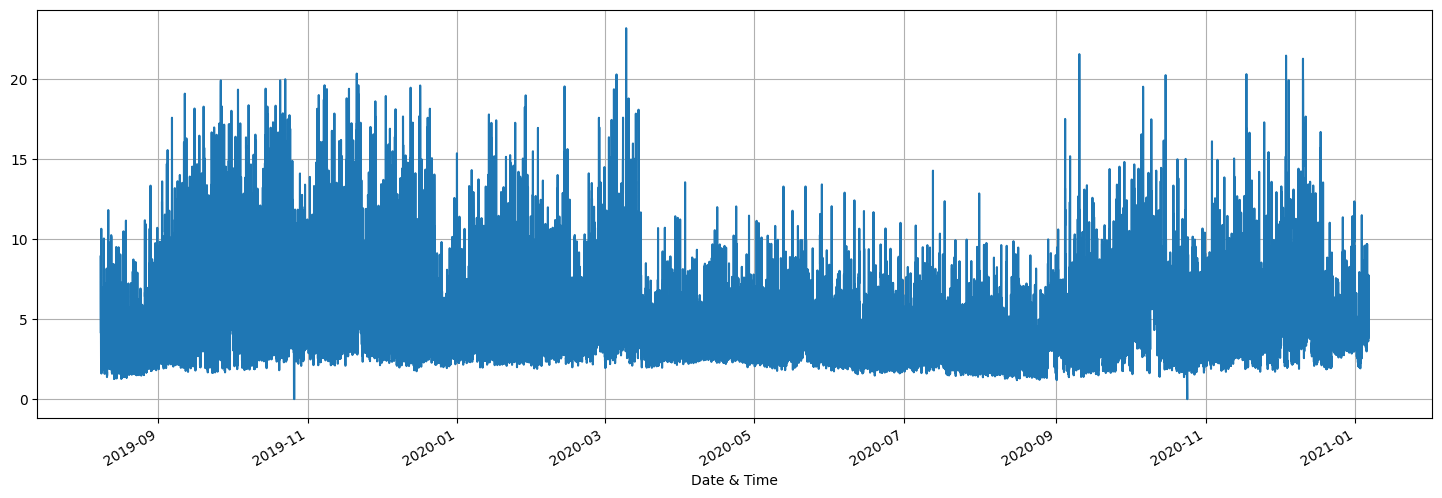

In [5]:
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
data['Generation [kW]'].plot(ax=ax)
plt.grid(True)
plt.show()

In [6]:
cols_of_interest = ['CT15_Amperage [A]', 'CT13_Amperage [A]', 'CT14_Amperage [A]', 'CT12_Amperage [A]', 'CT11_Amperage [A]', 'CT10_Amperage [A]', 'CT9_Amperage [A]', 'CT8_Amperage [A]', 'CT7_Amperage [A]', 'CT6_Amperage [A]', 'CT3_Amperage [A]', 'CT2_Amperage [A]']
data = data[cols_of_interest]
data.head()

,CT15_Amperage [A],CT13_Amperage [A],CT14_Amperage [A],CT12_Amperage [A],CT11_Amperage [A],CT10_Amperage [A],CT9_Amperage [A],CT8_Amperage [A],CT7_Amperage [A],CT6_Amperage [A],CT3_Amperage [A],CT2_Amperage [A]
Date & Time,,,,,,,,,,,,
2019-08-08 15:00:00,0.115783,0.130540,0.128536,1.947749,0.347324,0.317950,1.447450,0.885286,1.553972,6.973518,9.122383,9.701496
2019-08-08 15:15:00,0.117276,0.131006,0.128700,2.156672,0.371150,0.420760,1.574633,1.127057,1.528567,18.487846,17.092139,11.508376
2019-08-08 15:30:00,0.116692,0.130749,0.128777,1.740806,0.373436,0.221863,1.516158,0.679564,1.481699,11.531952,11.335806,11.244882
2019-08-08 15:45:00,0.111447,0.125818,0.123712,1.686262,0.308933,0.196249,1.477777,0.605557,1.498686,8.172528,8.843417,8.637452
2019-08-08 16:00:00,0.111589,0.124989,0.123486,1.591017,0.304450,0.220551,1.454292,0.587173,1.487338,10.654713,10.736909,8.866664


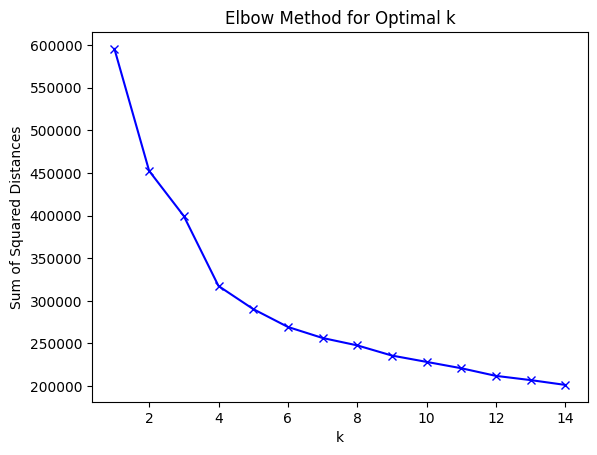

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Standardisation des données
X = StandardScaler().fit_transform(data)

# Définition de la plage de k
K = range(1, 15)

# Initialisation de la liste pour stocker les sommes des distances
sum_of_squared_distances = []

# Calcul de l'inertie pour chaque valeur de k
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

# Affichage du graphique pour la méthode du coude
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

## 3. Consultation de l'ordonnancement des données du dataset.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

#Clustering
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(X_scaled)
## TOUT SE JOUE SUR CES DEUX LIGNES , on reprend les labels du résultat de kmeans qui a fait le boulot pour nous
y_hat = kmeans.predict(X_scaled)
labels = kmeans.labels_
data['cluster'] = labels
data.head()

,CT15_Amperage [A],CT13_Amperage [A],CT14_Amperage [A],CT12_Amperage [A],CT11_Amperage [A],CT10_Amperage [A],CT9_Amperage [A],CT8_Amperage [A],CT7_Amperage [A],CT6_Amperage [A],CT3_Amperage [A],CT2_Amperage [A],cluster
Date & Time,,,,,,,,,,,,,
2019-08-08 15:00:00,0.115783,0.130540,0.128536,1.947749,0.347324,0.317950,1.447450,0.885286,1.553972,6.973518,9.122383,9.701496,0
2019-08-08 15:15:00,0.117276,0.131006,0.128700,2.156672,0.371150,0.420760,1.574633,1.127057,1.528567,18.487846,17.092139,11.508376,1
2019-08-08 15:30:00,0.116692,0.130749,0.128777,1.740806,0.373436,0.221863,1.516158,0.679564,1.481699,11.531952,11.335806,11.244882,0
2019-08-08 15:45:00,0.111447,0.125818,0.123712,1.686262,0.308933,0.196249,1.477777,0.605557,1.498686,8.172528,8.843417,8.637452,0
2019-08-08 16:00:00,0.111589,0.124989,0.123486,1.591017,0.304450,0.220551,1.454292,0.587173,1.487338,10.654713,10.736909,8.866664,0


## 4. Préparation de l'entrainement.

In [9]:
window_size = 400  # Taille de la fenêtre pour le CNN
def create_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        v = X.iloc[i:(i + window_size)].values
        if v.shape[0] == window_size:  
            Xs.append(v.reshape((window_size, -1)))  
            ys.append(y.iloc[i + window_size])
    return np.array(Xs), np.array(ys)

In [10]:
Xs, ys = [], []
for cluster in range(4):
    cluster_df = data[data['cluster'] == cluster]
    X, y = create_dataset(cluster_df[cols_of_interest], cluster_df['cluster'], window_size)
    if X.size > 0:  
        Xs.append(X)
        ys.append(y)


print("Distribution des clusters dans les données originales:")
print(data['cluster'].value_counts())

# Vérifier la distribution des clusters dans l'ensemble de test
print("\nDistribution des clusters dans l'ensemble de test:")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

# Vérifier la présence de chaque cluster dans Xs et ys
for i in range(10):
    if i < len(Xs) and i < len(ys):
        print(f"Cluster {i} - Taille de X: {Xs[i].shape[0]}, Taille de y: {ys[i].shape[0]}")
    else:
        print(f"Cluster {i} - Pas de données")

# Vérification des formes avant concaténation
for i, X in enumerate(Xs):
    print(f"Forme de X pour le cluster {i}: {X.shape}")
for i, y in enumerate(ys):
    print(f"Forme de y pour le cluster {i}: {y.shape}")

#Concaténation des données de chaque cluster
X_cnn = np.concatenate(Xs, axis=0)
y_cnn = np.concatenate(ys, axis=0)


Distribution des clusters dans les données originales:
cluster
1    20121
0    15111
2    10626
3     3764
Name: count, dtype: int64

Distribution des clusters dans l'ensemble de test:
{3: 3364}
Cluster 0 - Taille de X: 14711, Taille de y: 14711
Cluster 1 - Taille de X: 19721, Taille de y: 19721
Cluster 2 - Taille de X: 10226, Taille de y: 10226
Cluster 3 - Taille de X: 3364, Taille de y: 3364
Cluster 4 - Pas de données
Cluster 5 - Pas de données
Cluster 6 - Pas de données
Cluster 7 - Pas de données
Cluster 8 - Pas de données
Cluster 9 - Pas de données
Forme de X pour le cluster 0: (14711, 400, 12)
Forme de X pour le cluster 1: (19721, 400, 12)
Forme de X pour le cluster 2: (10226, 400, 12)
Forme de X pour le cluster 3: (3364, 400, 12)
Forme de y pour le cluster 0: (14711,)
Forme de y pour le cluster 1: (19721,)
Forme de y pour le cluster 2: (10226,)
Forme de y pour le cluster 3: (3364,)


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = min_max_scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [12]:
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

Création d'un réseau de convolution à une dimension.

In [13]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(400, 12)))
model.add(BatchNormalization())
model.add(Conv1D(32, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

One_Hot_Encoding

In [14]:
def one_hot_encode_classes(data, cols_of_interest):
    """
    Encode les colonnes spécifiées en utilisant le one-hot encoding.
    
    Args:
        data (pd.DataFrame): Le DataFrame contenant les données.
        cols_of_interest (list): Liste des noms des colonnes à encoder.
    
    Returns:
        np.ndarray: Matrice encodée sous forme de vecteurs one-hot.
    """
    encoder = OneHotEncoder()
    encoded_data = encoder.fit_transform(data[cols_of_interest])
    return encoded_data, encoder

In [15]:
# Encodage des colonnes sélectionnées
encoded_data, encoder = one_hot_encode_classes(data, cols_of_interest)

# Affichage de la forme des données encodées
print("Forme des données encodées :", encoded_data.shape)

# Exemple : premier vecteur one-hot
print("Exemple de vecteur one-hot pour la première ligne :", encoded_data[0])

Forme des données encodées : (49622, 529933)
Exemple de vecteur one-hot pour la première ligne : <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (1, 529933)>
  Coords	Values
  (0, 14311)	1.0
  (0, 61812)	1.0
  (0, 84641)	1.0
  (0, 114197)	1.0
  (0, 142873)	1.0
  (0, 189813)	1.0
  (0, 234162)	1.0
  (0, 291210)	1.0
  (0, 341527)	1.0
  (0, 406891)	1.0
  (0, 448230)	1.0
  (0, 503167)	1.0


## 5. Entrainement

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1201/1201 [==============================] - 8s 5ms/step - loss: 0.0351 - accuracy: 0.9930
Epoch 2/10
1201/1201 [==============================] - 7s 5ms/step - loss: 0.0056 - accuracy: 0.9988
Epoch 3/10
1201/1201 [==============================] - 7s 6ms/step - loss: 0.0183 - accuracy: 0.9969
Epoch 4/10
1201/1201 [==============================] - 7s 5ms/step - loss: 0.0074 - accuracy: 0.9986
Epoch 5/10
1201/1201 [==============================] - 7s 6ms/step - loss: 0.0073 - accuracy: 0.9990
Epoch 6/10
1201/1201 [==============================] - 6s 5ms/step - loss: 0.0021 - accuracy: 0.9996
Epoch 7/10
1201/1201 [==============================] - 6s 5ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 8/10
1201/1201 [==============================] - 7s 6ms/step - loss: 0.0047 - accuracy: 0.9991
Epoch 9/10
1201/1201 [==============================] - 7s 6ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 10/10
1201/1201 [==============================] - 6s 5ms/step - loss: 0.002

## 7. Matrice de confusion

Création d'une matrice de confusion pour identifier la justesse de notre réseau et pour analyser quelles sont les types de catégories mal classés

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
y_pred2=model.predict(X_test)
y_pred2=np.argmax(y_pred2, axis=1)
y_test2=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test2, y_pred2)

301/301 [==============================] - 1s 1ms/step


In [19]:
print(y_pred2,y_test2)

[1 1 0 ... 2 1 1] [1 1 0 ... 2 1 1]


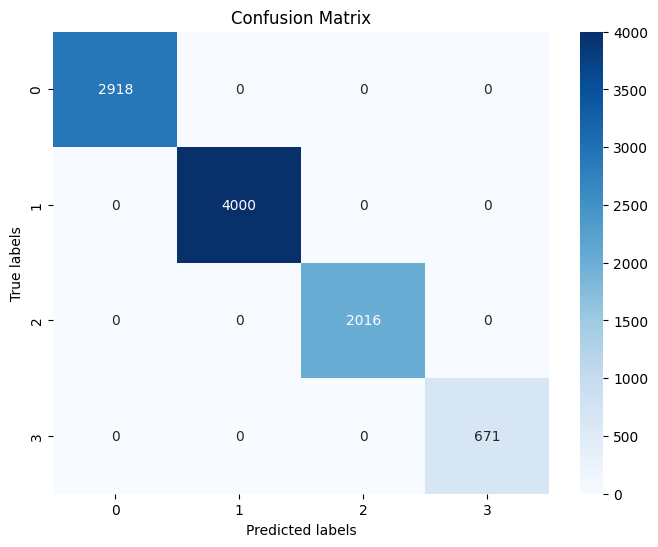

In [20]:
# Affichage de la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()